In [3]:
import sys
import glob
import pandas as pd
import numpy as np
import re
import pickle

from ngskit.analysis import *
from sklearn.utils import shuffle


all_amino = ['_','C', 'V', 'T', 'F', 'Y', 'A', 'P', 'W', 'I', 'M', 'L', 'S', 'G', 'H', 'D', 'E', 'N', 'Q', 'R', 'K']
n_amino = len(all_amino)
aa_to_int = dict((c, i) for i, c in enumerate(all_amino))

int_to_aa = dict((c, i) for i, c in aa_to_int.items())



aa_one_hot = dict()
for a,i in aa_to_int.items():
    v = np.zeros(len(aa_to_int))
    v[i] = 1
    aa_one_hot[a] = v
    
triplets = list()
bases = ['A','C' ,'G', 'T']

for b1 in bases:
    for b2 in bases:
        for b3 in bases:
            triplets.append(b1+b2+b3)
            
n_bases = len(bases)

base_to_int = dict((c, i) for i, c in enumerate(bases))
int_to_base = dict((c, i) for i, c in base_to_int.items())



base_one_hot = dict()
for a,i in base_to_int.items():
    v = np.zeros(len(base_to_int))
    v[i] = 1
    base_one_hot[a] = v







def _tofreq(value, maxim):
    b = maxim / np.log(50)
    
    #a =   math.pow(10, value) /4
    a = np.exp(value / b)
    #print(a)
    return a + 0.00000001
    
def __resize(vectors):
    matrix = list()
    for i in range(0,len(vectors),4):
        matrix.append(vectors[i:i+4])
    m =  pd.DataFrame(matrix, index=list(range(3)),columns=('A','C','G','T')  ).T
    m=  m.T.as_matrix()
    return np.reshape(m,(12))


def timscore2freq(vectors):
    matrix = list()
    for i in range(0,len(vectors),4):
        matrix.append(vectors[i:i+4])
    m =  pd.DataFrame(matrix, index=list(range(3)),columns=( 'A','C' ,'G', 'T')  ).T
    max_range = max(m.max() - m.min())
    m=  m.apply(_tofreq, maxim=max_range, axis=1)
    m =  m / m.sum()
    m=  m.T.as_matrix()
    return np.reshape(m,(12))


def _itersplit_motif(zfinger):
    region = list()
    # Reg 0
    zfinger = 'X'+ zfinger
    re_motifs = [ '.{1,5}C.{11,15}H.{2,6}[HC]', '.{1,5}C.{11,15}H',]
    
    seq = re.findall(re_motifs[0],zfinger )
    if seq:
        seq = re.findall(re_motifs[1],seq[0])

    
    return seq



def extract_spec_res_tim(zfinger):
    parts = list()
    zregion = _itersplit_motif(zfinger)
    if len(zregion) !=0:
        for i in [-8,-7,-6,-5,-3,-2]:
            parts.append(zregion[0][i:i+1])
        return ''.join(parts)
    return None


def extract_spec_res_GSD(zfinger):
    parts = list()
    #zregion = itersplit_motif(zfinger)
    #print(zregion)
    if len(zfinger) !=0:
        for i in [-8,-7,-6,-5,-3,-2]:
            parts.append(zfinger[i:i+1])
        return ''.join(parts)
    return None



def extract_spec_res_marcus(zfinger):
    parts = list()
    #zregion = itersplit_motif(zfinger)
    if len(zfinger) !=0:
        for i in [8,9,10,11,13,14]:
            parts.append(zfinger[i:i+1])
        return ''.join(parts)
    return None




def marcusdf2pfm(Seq, df, ignore_if = None):
    temp = df[df['Seq']==Seq]
    buffer = list()
    #return temp
    for triplet in triplets.keys():
        if triplet in temp['Triplet'].values:
            amount = a['Reads'][a['Triplet']==triplet].values[0]
            if ignore_if:
                if ignore_if > amount:
                    continue
            
            for x in range(int(amount)):
                buffer.append(triplet)
                
    pf = get_ppm(buffer,pseudocounts=0, elements=bases)
    return pf

def onehot_seq(seq, kind = 'aa'):
    if kind == 'aa':
        one_hot = aa_one_hot
    else:
        one_hot = base_one_hot
        
    _one_hot_seq =  list()
    for s in seq:
        _one_hot_seq.append(one_hot[s])
    
    return np.asarray(_one_hot_seq)



def revertoseq(vec, kind='aa'):
    
    if kind == 'aa':
        int_to_char = int_to_aa
    else:
        int_to_char = int_to_base
    
    seq = list()
    for i in vec:
        c = list(i > 0)
        seq.append(int_to_char[c.index(True)])
    return ''.join(seq)

# Vecotirize
from ngskit.analysis  import *
# scale
norm_props = dict()
for prop, data in aa_property_tables.items():
    minprop = min(data.values())
    maxprop = max(data.values())
    c = maxprop - minprop
    norm = dict()
    for aa, value in data.items():
        norm[aa] = (value - minprop) / c
    norm_props[prop] = norm
    
    
def embeedings(seq):
    
    vec = np.zeros((len(seq),6))
    
    for idx,a in enumerate(seq):
        vec[idx][0] = norm_props['charge'].get(a, 0.0)
        vec[idx][1] = norm_props['polarity'].get(a, 0.0)
        vec[idx][2] = norm_props['hydrophobicity'].get(a, 0.0)
        vec[idx][3] = norm_props['volume'].get(a, 0.0)
        vec[idx][4] = norm_props['local_flexibility'].get(a, 0.0)
        vec[idx][5] = norm_props['pK'].get(a, 0.0)
    return vec

def get_decoder():
    decoder = dict()
    for a in norm_props['charge'].keys():
        indx = list()
        for p in ['charge','polarity', 'hydrophobicity', 'volume', 'local_flexibility','pK']:
            indx.append(norm_props[p].get(a, 0.0))
        decoder[set(indx)]= a
        
    return decoder


def encode_data(df):
    dataX_Tim = list()
    dataY_Tim = list()
    for idx, row in df.iterrows():

        seq_out = row['Seq'].replace('X','A')
        #reprocess = extract_motifs(seq_out)
        #seq_out = ''.join(reprocess)
        try:
            #zmotif = itersplit_motif(seq_out)
            #seq_out = extract_spec_res_marcus(seq_out)
            seq_out = seq_out.replace('X','A')
        except:
            continue
        query = onehot_seq(seq_out, kind = 'aa')
        #while len(query) < 29:
        #    query.append(0)

        query = np.array(query)
        query = np.reshape(query,(6,21,1))
        #target = [to_one_hot[char] for char in seq_out]
        features = [ 'A1', 'C1', 'G1', 'T1', 'A2', 'C2', 'G2', 'T2', 'A3', 'C3', 'G3', 'T3'] #'A4', 'C4', 'G4', 'T4',]

        target = row[features]

        target = np.array(target)
        #target = __convertscore2freq(target)
        #dataX.append(np.reshape(result, (1, result.shape[0], result.shape[1])))
        #dataY.append(np.array(to_one_hot[seq_out]))
        dataX_Tim.append(query)
        dataY_Tim.append(target)
    
    X =  np.asarray(dataX_Tim)
    y = np.asarray(dataY_Tim)

    X, y = shuffle(X,y)
    
    return X, y



#s = "DICGRKFRSGSALWHHTKIHLRQKD"
# function to transform reads to pfm
# no pseudo counts allowed
def calc_ppm(s, ddf):
    df = ddf[ddf['Seq']==s]
    buffer = list()
    for t in triplets:
        if t in df['Triplet'].values:
            rep = df[(df['Triplet']==t)]['Reads'].values[0]
            for i in range(int(rep)):
                buffer.append(t)
    freqs = get_ppm(buffer,elements=bases,pseudocounts=0.0)
    return list(freqs.values.flatten(order='F'))

def calc_ppm_log_flat(s, ddf):
    df = ddf[ddf['Seq']==s]
    buffer = list()
    for t in triplets:
        if t in df['Triplet'].values:
            rep = df[(df['Triplet']==t)]['Reads'].values[0]
            rep = int(np.log10(rep)) 
            for i in range(int(rep)):
                buffer.append(t)
    freqs = get_ppm(buffer,elements=bases,pseudocounts=0.0)
    return list(freqs.values.flatten(order='F'))


def calc_ppm_flat(s, ddf):
    df = ddf[ddf['Seq']==s]
    buffer = list()
    for t in triplets:
        if t in df['Triplet'].values:
            rep = df[(df['Triplet']==t)]['Reads'].values[0]
            rep = 1
            for i in range(int(rep)):
                buffer.append(t)
    freqs = get_ppm(buffer,elements=bases,pseudocounts=0.0)
    return list(freqs.values.flatten(order='F'))


def calc_ppm_usingnormreads(s, ddf):
    df = ddf[ddf['Seq']==s]
    buffer = list()
    for t in triplets:
        if t in df['Triplet'].values:
            rep = df[(df['Triplet']==t)]['nReads'].values[0]
            #print(df)
            for i in range(int(rep)):
                buffer.append(t)
    try:
        freqs = get_ppm(buffer,elements=bases,pseudocounts=0.0)

    except Exception as e:
        print(rep)
        print('s')
        raise e

    return list(freqs.values.flatten(order='F'))

def loground(val):
    return round(np.log2(val))

# put all triplets togheter



In [65]:
def load_data(mode):
    collector = list()
    for t in  triplets:
        try:
            df = pd.read_csv(f'/home/kimlab2/ccorbi/MARCUS_ZF/preprocess/{mode}_{t}_preprocess.csv')
            df['Triplet'] = t
            collector.append(df)
        except:
            print('Something went wrong for {}'.format(t))
            pass


    mergeddf = pd.concat(collector)
    return mergeddf

In [66]:
mode_rs = load_data('RS')

Something went wrong for GAT
Something went wrong for GTG
Something went wrong for TCA


In [67]:
mode_rs.head(3)

Seq  Reads  Var         E Triplet
0  AFCGRKFSRVLNLTWHTKIHLRQKD    2.0    2  0.062132     AAA
1  AICGRKFSKSPGLCNHTKIHLRQKD    2.0    2  0.068919     AAA
2  DICERKFSRDQNLKYHTKIHLRQKD    2.0    2  0.095150     AAA

In [68]:
import  matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

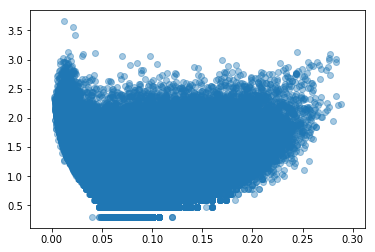

In [69]:
plt.scatter(mode_rs.E,np.log10(mode_rs.Reads), alpha=.4)

\begin{equation*}
\left( \sum_{k=1}^n a_k b_k \right)^2 \leq \left( \sum_{k=1}^n a_k^2 \right) \left( \sum_{k=1}^n b_k^2 \right)
\end{equation*}

$$
E'   = - \frac{1}{\log_2 (N)} \sum_{i=1}p(i) \log_2 p(i)
$$

In [98]:
def filter_data(df, READS_CUTOFF=15, E_CUTOFF=.07):
    print(df.shape)
    mergeddf = df[df['Seq'].str.contains(r'DICGRKF.....L..HTKIHLRQKD')]
    print('#{} filter 1 '.format(mergeddf.shape[0]))
    
    mergeddf = mergeddf[mergeddf['Reads']>READS_CUTOFF]
    #print(mergeddf.shape)
    
    #rint(mergeddf.shape)
    print('#{} filter 2 '.format(mergeddf.shape[0]))
    #mergeddf['LReads'] = mergeddf['Reads'].apply(loground)
    #filter 3
    mergeddf = mergeddf[mergeddf['E']>=E_CUTOFF]
    print('#{} filter 3 '.format(mergeddf.shape[0]))
    return mergeddf
    

In [99]:
filter_data(mode_rs)['Seq'].unique().shape

(282348, 5)
#277812 filter 1 
#57497 filter 2 
#37980 filter 3 


(29053,)

In [100]:
modes = ['RS', 'RA', 'MODE2', 'MODE3', 'MODE4', 'MODE5', 'MODE6']

In [101]:
for m in modes:
    print(m)
    temp = load_data(m)
    print(filter_data(temp)['Seq'].unique().shape)

RS
Something went wrong for GAT
Something went wrong for GTG
Something went wrong for TCA
(282348, 5)
#277812 filter 1 
#57497 filter 2 
#37980 filter 3 
(29053,)
RA
Something went wrong for GAT
Something went wrong for TAG
Something went wrong for TCA
(313752, 5)
#308220 filter 1 
#53322 filter 2 
#38980 filter 3 
(30510,)
MODE2
(138405, 5)
#136105 filter 1 
#30370 filter 2 
#16995 filter 3 
(13289,)
MODE3
(87988, 5)
#84526 filter 1 
#20339 filter 2 
#12370 filter 3 
(8779,)
MODE4
(150981, 5)
#144058 filter 1 
#47736 filter 2 
#19850 filter 3 
(15212,)
MODE5
(63979, 5)
#57028 filter 1 
#24653 filter 2 
#14424 filter 3 
(9479,)
MODE6
(106603, 5)
#104095 filter 1 
#31506 filter 2 
#16737 filter 3 
(12547,)


In [103]:
for m in modes:
    print(m)
    temp = load_data(m)
    print(np.median(temp.E))

RS
Something went wrong for GAT
Something went wrong for GTG
Something went wrong for TCA
0.07181425241747805
RA
Something went wrong for GAT
Something went wrong for TAG
Something went wrong for TCA
0.07737056144690832
MODE2
0.07012708988633652
MODE3
0.07094846566967605
MODE4
0.06624825371528141
MODE5
0.07885247563522547
MODE6
0.07094846566967605


In [105]:
for m in modes:
    print(m)
    temp = load_data(m )
    print(filter_data(temp, E_CUTOFF=.1)['Seq'].unique().shape)

RS
Something went wrong for GAT
Something went wrong for GTG
Something went wrong for TCA
(282348, 5)
#277812 filter 1 
#57497 filter 2 
#28761 filter 3 
(21820,)
RA
Something went wrong for GAT
Something went wrong for TAG
Something went wrong for TCA
(313752, 5)
#308220 filter 1 
#53322 filter 2 
#32897 filter 3 
(25628,)
MODE2
(138405, 5)
#136105 filter 1 
#30370 filter 2 
#12694 filter 3 
(9977,)
MODE3
(87988, 5)
#84526 filter 1 
#20339 filter 2 
#9981 filter 3 
(7186,)
MODE4
(150981, 5)
#144058 filter 1 
#47736 filter 2 
#13845 filter 3 
(10797,)
MODE5
(63979, 5)
#57028 filter 1 
#24653 filter 2 
#12444 filter 3 
(8231,)
MODE6
(106603, 5)
#104095 filter 1 
#31506 filter 2 
#13337 filter 3 
(10099,)


In [106]:
for m in modes:
    print(m)
    temp = load_data(m )
    print(filter_data(temp, E_CUTOFF=.15)['Seq'].unique().shape)

RS
Something went wrong for GAT
Something went wrong for GTG
Something went wrong for TCA
(282348, 5)
#277812 filter 1 
#57497 filter 2 
#12386 filter 3 
(9526,)
RA
Something went wrong for GAT
Something went wrong for TAG
Something went wrong for TCA
(313752, 5)
#308220 filter 1 
#53322 filter 2 
#20362 filter 3 
(15683,)
MODE2
(138405, 5)
#136105 filter 1 
#30370 filter 2 
#6022 filter 3 
(4832,)
MODE3
(87988, 5)
#84526 filter 1 
#20339 filter 2 
#5345 filter 3 
(4005,)
MODE4
(150981, 5)
#144058 filter 1 
#47736 filter 2 
#5026 filter 3 
(4140,)
MODE5
(63979, 5)
#57028 filter 1 
#24653 filter 2 
#8147 filter 3 
(5580,)
MODE6
(106603, 5)
#104095 filter 1 
#31506 filter 2 
#7018 filter 3 
(5583,)


In [6]:
import math
def entro(freqList):
    # Shannon entropy
    ent = 0.0
    for freq in freqList:
        try:
            ent = ent + freq * math.log(freq, 2)
        except:
            pass
    ent = -ent
    return ent

In [8]:
entro([10,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0])

-33.219280948873624

ValueError: math domain error

In [82]:
#106603 RAW SEQ in MODE6
normreads
#104095 Filter1 SEQ in MODE6
#31506 Filter2 SEQ in MODE6
#16737 Filter3 SEQ in MODE6
#12547 SEQs in MODE6 to parse
#12547 SEQs in MODE6 parsed
#12547 SEQs in MODE6 encoded
#9972 SEQs in MODE6 encoded Traning Dataset


s


In [76]:
m6 = filter_data(temp)

(106603, 5)
(31565, 5)
(31506, 5)
#31506 filter 2 
#16737 filter 3 


In [ ]:
m6.head(3)

In [ ]:
def calc_ppm_usingnormreads(s, ddf):
    df = ddf[ddf['Seq']==s]
    buffer = list()
    for t in triplets:
        if t in df['Triplet'].values:
            rep = df[(df['Triplet']==t)]['nReads'].values[0]
            for i in range(int(round(rep))):
                buffer.append(t)
    try:
        freqs = get_ppm(buffer,elements=bases,pseudocounts=0.0)

    except Exception as e:
        print(rep)
        print(s)
        print(buffer)
        raise e

    return list(freqs.values.flatten(order='F'))

In [53]:
type(round(1.4125117472608282))

int

In [54]:
seq_poll = m6['Seq'].unique()
m6['nReads'] =  np.log2(m6['Reads']/m6['Reads'].sum()*1_000_000)

# transform and generate a new dataframe 
# Seq  'A1', 'C1', 'G1', 'T1', 'A2', 'C2', 'G2', 'T2', 'A3', 'C3', 'G3', 'T3'
totals = list()
for s in seq_poll:
    ppm = calc_ppm_usingnormreads(s, m6)
    totals.append([s]+ppm)
# Pandify 
fet= [ 'A1', 'C1', 'G1', 'T1', 'A2', 'C2', 'G2', 'T2', 'A3', 'C3', 'G3', 'T3']
na = ['Seq'] + fet
totals = pd.DataFrame(totals, columns=na)

In [55]:
totals.shape

(104752, 13)

In [ ]:
for idx, row in df.iterrows():

        seq_out = row['Seq'].replace('X','A')
        #reprocess = extract_motifs(seq_out)
        #seq_out = ''.join(reprocess)
        #try:
            #zmotif = itersplit_motif(seq_out)
        seq_out = extract_spec_res_marcus(seq_out)

In [26]:
import pickle

In [29]:
folder_data = '/home/kimlab2/ccorbi/MARCUS_ZF/preprocess/'
mode = 'MODE6'
rfn = 'normreads'
rcut= 15
ecut = '0.07'
pikmode6 = pickle.load(open('{}/{}_Xtrain_{}_{}_{}.pkl'.format(folder_data,mode,rfn,rcut, ecut),'rb'))

In [30]:
pikmode6.shape

(10014, 6, 21, 1)

In [ ]:
pikmode6 = pickle.load(open('{}/{}_Xtrain_{}_{}_{}.pkl'.format(folder_data,mode,rfn,rcut, ecut),'rb'))